In [1]:
!pip install -q tf-nightly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.2/490.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.3 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pathlib
data_dir = '/content/drive/MyDrive/colab/clothes_classification/train/train_to_black'
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

1004


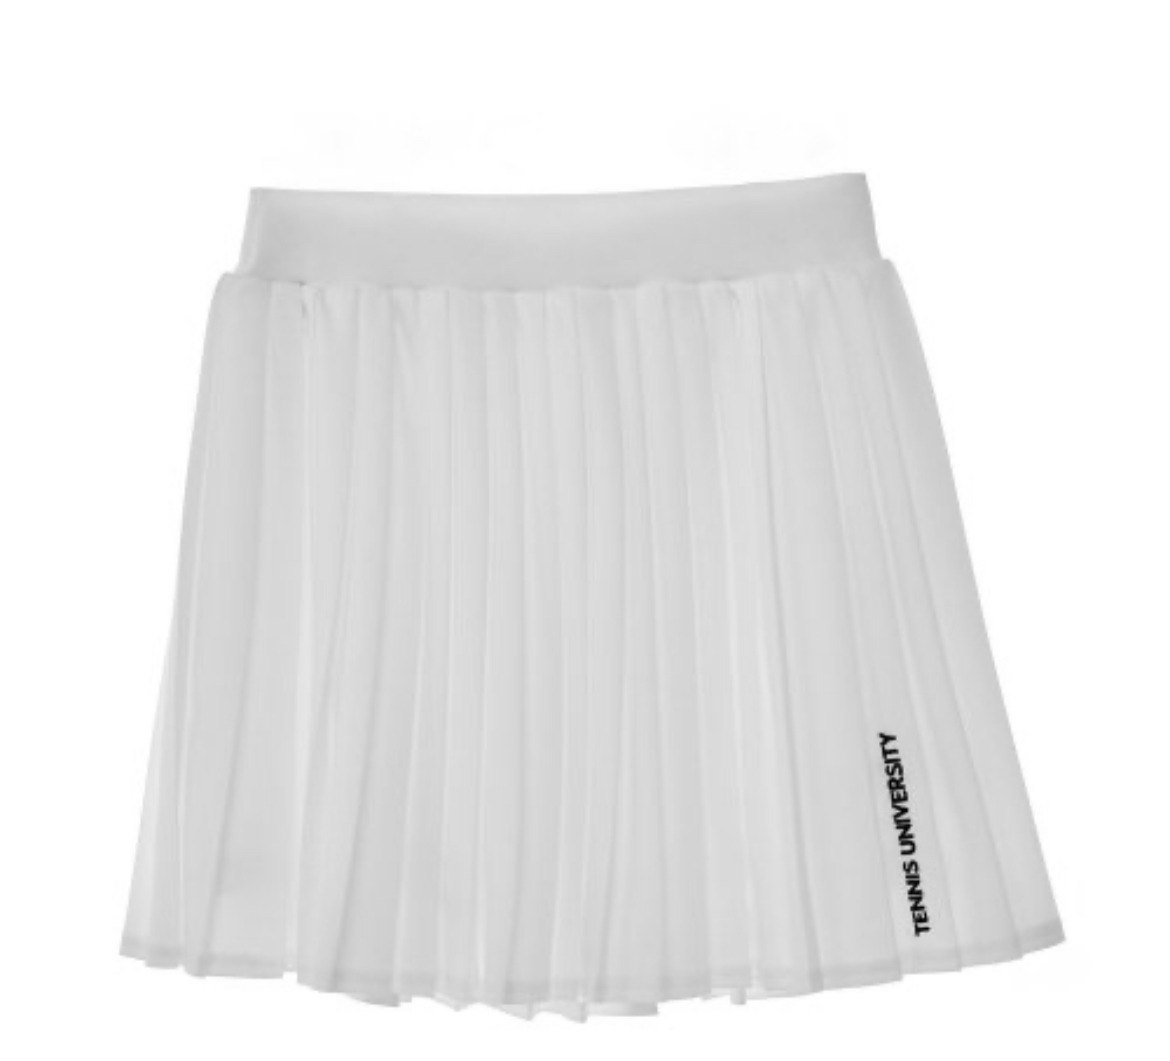

In [6]:
clothes = list(data_dir.glob('Skirt/*'))
PIL.Image.open(str(clothes[20]))

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1022 files belonging to 9 classes.
Using 818 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1022 files belonging to 9 classes.
Using 204 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Bag', 'Blouse', 'Jacket', 'Onepiece', 'Padding', 'Pants', 'Shirts', 'Skirt', 'T-Shirt']


In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.039730426 1.0


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization

# ResNet50 모델 로드
base_model = ResNet50(input_shape=(img_height, img_width, 3),
                      include_top=False,  # 최상위 분류기 제외
                      weights='imagenet')

# 모델 학습 방지
for layer in base_model.layers:
    layer.trainable = False

# 사용자 정의 모델 정의
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout 레이어 추가
    Dense(9, activation='softmax')  # 9개의 클래스가 있다고 가정
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 256)               18874624  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 42464649 (161.99 MB)
Trainable params: 18876937 (72.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
epochs=15
history1 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
26/26 [==============================] - 15s 225ms/step - loss: 12.8710 - accuracy: 0.5685 - val_loss: 1.0831 - val_accuracy: 0.8382
Epoch 2/15
26/26 [==============================] - 3s 131ms/step - loss: 1.2244 - accuracy: 0.7751 - val_loss: 0.6157 - val_accuracy: 0.8284
Epoch 3/15
26/26 [==============================] - 4s 160ms/step - loss: 0.6131 - accuracy: 0.8081 - val_loss: 0.5960 - val_accuracy: 0.8529
Epoch 4/15
26/26 [==============================] - 3s 130ms/step - loss: 0.5570 - accuracy: 0.8313 - val_loss: 0.4612 - val_accuracy: 0.8676
Epoch 5/15
26/26 [==============================] - 3s 130ms/step - loss: 0.5610 - accuracy: 0.8423 - val_loss: 0.3705 - val_accuracy: 0.8873
Epoch 6/15
26/26 [==============================] - 4s 173ms/step - loss: 0.4921 - accuracy: 0.8753 - val_loss: 0.5145 - val_accuracy: 0.8971
Epoch 7/15
26/26 [==============================] - 4s 159ms/step - loss: 0.4624 - accuracy: 0.8802 - val_loss: 0.8014 - val_accuracy: 0.8775
Epoc

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

In [ ]:
model.evaluate(val_ds)

7/7 [==============================] - 37s 165ms/step - loss: 0.4564 - accuracy: 0.8971


[0.45644867420196533, 0.8970588445663452]

In [ ]:
test_dir = '/content/drive/MyDrive/colab/clothes_classification/test/test_to_black'
test_dir = pathlib.Path(test_dir)

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 103 files belonging to 9 classes.


In [ ]:
model.evaluate(test_ds)

4/4 [==============================] - 15s 241ms/step - loss: 1.1763 - accuracy: 0.8155


[1.1762559413909912, 0.8155339956283569]

In [ ]:
!pip install koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 21.3 MB/s eta 0:00:00


In [ ]:
import koreanize_matplotlib

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 모델 저장
from tensorflow import keras

keras.models.save_model(model, '/content/drive/MyDrive/colab/clothes_classification/resnet_model')

In [14]:
# 모델 로드
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/colab/clothes_classification/resnet_model')

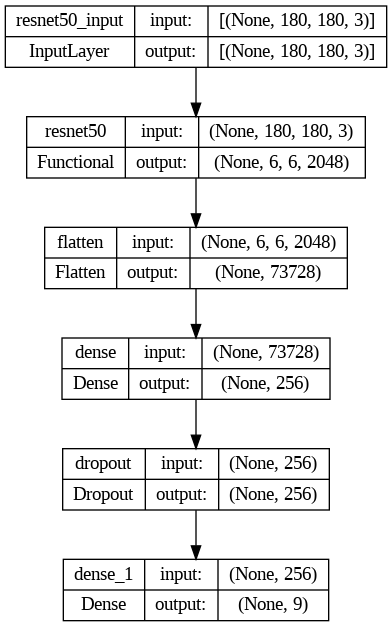

In [15]:
from tensorflow.keras.utils import plot_model

# ... (이전 코드)

# 모델의 구조를 그림 파일로 저장
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)


Saving Tt (6).jpg to Tt (6).jpg


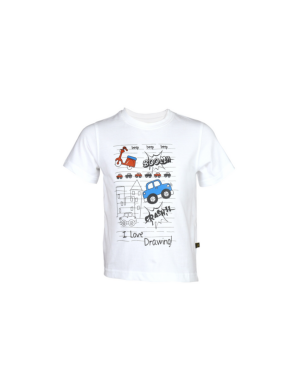

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image

# 이미지 업로드
uploaded_img = files.upload()
img_path = list(uploaded_img.keys())[0]

# 이미지를 PIL 객체로 열기
img = Image.open(img_path)

# 이미지 출력
plt.imshow(img)
plt.axis('off')  # 축 정보를 없애줍니다.
plt.show()


In [ ]:
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

In [ ]:
clothes_path = img_path

img = keras.preprocessing.image.load_img(
    clothes_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)

1/1 [==============================] - 0s 25ms/step
This image most likely belongs to T-Shirt.


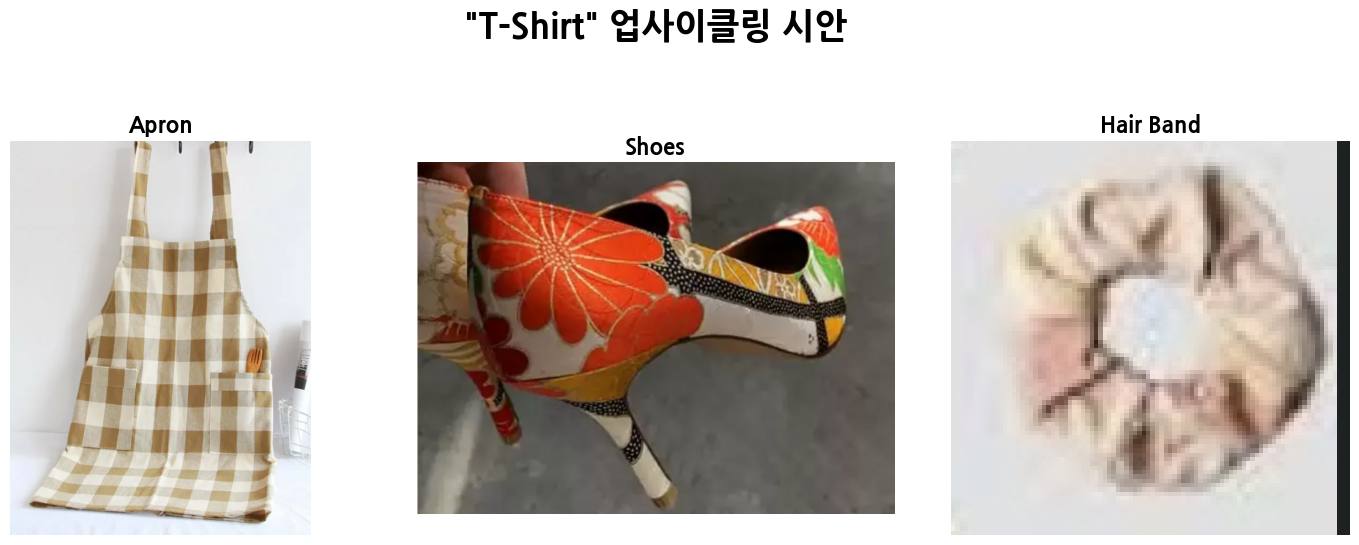

reform Link 1,reform Link 2,reform Link 3


In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, HTML

clothes = class_names[np.argmax(score)]

# 리폼 폴더 경로 지정
reform_path = os.path.join("/content/drive/MyDrive/colab/clothes_classification/refrom", clothes)

# 해당 폴더 내의 모든 폴더 목록을 가져옵니다.
sub_folders = [f for f in os.listdir(reform_path) if os.path.isdir(os.path.join(reform_path, f))]

# 랜덤하게 3개의 폴더를 선택합니다.
selected_folders = random.sample(sub_folders, 3)

# 각 폴더에서 랜덤하게 1개의 이미지를 선택하고 보여줍니다.
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# 상단 제목 설정
fig.suptitle(f'"{clothes}" 업사이클링 시안', fontsize=25, fontweight='bold', y=1.08)

for ax, folder in zip(axes, selected_folders):
    image_files = [f for f in os.listdir(os.path.join(reform_path, folder)) if os.path.isfile(os.path.join(reform_path, folder, f))]
    selected_image = random.choice(image_files)
    image_path = os.path.join(reform_path, folder, selected_image)

    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(folder, fontsize=16, fontweight='bold') # 폴더 이름을 이미지 아래에 출력합니다.

plt.tight_layout()  # 서브플롯 간격 조절
plt.show()

# 이미지 아래에 각 이미지별로 링크를 표시하기 위해 HTML의 테이블을 사용합니다.
def make_clickable_link(val, link_text="Link"):
    """URL과 링크 텍스트를 받아서 HTML 링크를 생성하는 함수입니다."""
    return f'<a target="_blank" href="{val}">{link_text}</a>'

link_texts = ["reform Link 1", "reform Link 2", "reform Link 3"]

table_html = "<table><tr>"
+ "".join([f"<td style='text-align: center; padding: 0 175px;'>{make_clickable_link('http://www.dwlf.co.kr/', link_text)}</td>" for link_text in link_texts])
+ "</tr></table>"
display(HTML(table_html))
